In [1]:
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from pprint import pprint
import sklearn
from sklearn import datasets
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial import distance
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/")
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/lib/")
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/data_pkls/")

In [3]:
from cnn_dataset import cnn_dataset
import img_shows
importlib.reload(img_shows)
from img_shows import *

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
data_pkls = "../data_pkls/"
dates = None
with open(data_pkls + "dates123m.pkl", "rb") as pkl:
    dates = pickle.load(pkl)
len1 = 14513
dates = dates[len1:]
data_size = len(dates)
print(data_size)

28933


In [6]:
num_clusters = 20
path_imgs = "../data_pkls/imgs224_40_123m/"
pkl_files = [path_imgs + str(i+1) + ".pkl" for i in range(10, 30)]
path_labels = "../data_pkls/labels/"
pkl_labels = path_labels+ "labels" + str(num_clusters) +  "_23m" + ".pkl"
sparse_dataset = cnn_dataset(pkl_files, pkl_labels, classes=num_clusters, interval = 20)
print(len(sparse_dataset))

1447


In [7]:
path_hidden = "../data_pkls/hidden_vecs/"
with open(path_hidden + "hidden_mus64_convvae224.pkl", "rb") as f:
    hidden_mus = pickle.load(f)

In [8]:
with open("../data_pkls/cnn_predict.pkl", "rb") as f:
    preds = pickle.load(f)

In [9]:
with open(pkl_labels, "rb") as f:
    labels = pickle.load(f)

# ラベルと潜在ベクトルの位置を見る

In [10]:
indices = np.array(list(range(data_size))[::20])
sparse_preds = preds[indices]
sparse_labels = labels[indices]
sparse_hidden = hidden_mus[indices]
sparse_dates = [dates[i] for i in indices]
print(indices.shape)

(1447,)


In [11]:
#tsne_hiddens = [TSNE(perplexity=5, n_iter=2000, n_components=2, random_state=0).fit_transform(sparse_hidden) for p in [5,15,30,60,100]]
#with open("tsne_hiddens.pkl", "wb") as f:
#    pickle.dump(tsne_hiddens, f)

In [12]:
with open("tsne_hiddens.pkl", "rb") as f:
    tsne_hiddens = pickle.load(f)

In [13]:
print(sparse_preds.shape)
print(sparse_labels.shape)
print(sparse_hidden.shape)
print(len(sparse_dates))
print(tsne_hiddens[2].shape)

(1447,)
(1447,)
(1447, 64)
1447
(1447, 2)


In [14]:
def tsne_plots(tsne_hidden, sparse_preds, num_labels = 20, figsize=(15.0, 15.0), shock_poses = None):
    plt.clf()
    fig = plt.figure(figsize=figsize)
    for i in range(num_labels):
        poses = np.where(sparse_preds == i)[0]
        r = int(255 * i / 20)
        g = 255 - int(255 * i / 20)
        b = int(255) if i % 2 == 0 else 0
        color =  "#" + format(r, '02x') + format(g, '02x') + format(b, '02x')
        ax = fig.add_subplot(np.ceil(np.sqrt(num_labels)).astype("int64"), np.ceil(np.sqrt(num_labels)).astype("int64"), i + 1)
        ax.set_title("label " + str(i))
        ax.set_xlim([np.min(tsne_hidden[:, 0]) * 1.05,np.max(tsne_hidden[:, 0]) * 1.05])
        ax.set_ylim([np.min(tsne_hidden[:, 1]) * 1.05,np.max(tsne_hidden[:, 1]) * 1.05])
        ax.scatter(tsne_hidden[poses, 0], tsne_hidden[poses, 1], c =color, s=20, label=str(i))
        if shock_poses is not None:
            for pos in poses:
                if pos in shock_poses:
                    ax.scatter(tsne_hidden[pos, 0], tsne_hidden[pos, 1], c = "#000000", s=1000, label="shock", marker="$S" + str(pos) + "$")
    fig.tight_layout()
    plt.show()

In [15]:
def tsne_full_plot(tsne_hidden, sparse_preds, num_labels = 20, figsize=(15.0, 15.0), label_ranges = None, shock_poses = None):
    if label_ranges is None:
        label_ranges = range(num_labels)
    plt.clf()
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1,1,1)
    for i in label_ranges:
        poses = np.where(sparse_preds == i)[0]
        r = int(255 * i / 20)
        g = 255 - int(255 * i / 20)
        b = int(255) if i % 2 == 0 else 0
        color =  "#" + format(r, '02x') + format(g, '02x') + format(b, '02x')
        ax.scatter(tsne_hidden[poses, 0], tsne_hidden[poses, 1], c = color, s=100, label=str(i), marker="$" + str(i) + "$")
    if shock_poses is not None:
        for i in shock_poses:
            ax.scatter(tsne_hidden[i, 0], tsne_hidden[i, 1], c = "#000000", s=1000, label="shock", marker="$S" + str(i) + "$")
    ax.set_title('tsne')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([np.min(tsne_hidden[:, 0]) * 1.05,np.max(tsne_hidden[:, 0]) * 1.05])
    ax.set_ylim([np.min(tsne_hidden[:, 1]) * 1.05,np.max(tsne_hidden[:, 1]) * 1.05])
    ax.grid(True)
    ax.legend(loc='upper left', borderaxespad=0, bbox_to_anchor=(1.05, 1))
    fig.show()

In [16]:
for i, date in enumerate(sparse_dates):
    print(i, date)

0 ('1962-01-03', '1962-03-30')
1 ('1962-01-31', '1962-04-30')
2 ('1962-03-02', '1962-05-28')
3 ('1962-03-30', '1962-06-26')
4 ('1962-04-30', '1962-07-25')
5 ('1962-05-28', '1962-08-22')
6 ('1962-06-26', '1962-09-20')
7 ('1962-07-25', '1962-10-19')
8 ('1962-08-22', '1962-11-20')
9 ('1962-09-20', '1962-12-19')
10 ('1962-10-19', '1963-01-18')
11 ('1962-11-20', '1963-02-18')
12 ('1962-12-19', '1963-03-19')
13 ('1963-01-18', '1963-04-17')
14 ('1963-02-18', '1963-05-15')
15 ('1963-03-19', '1963-06-13')
16 ('1963-04-17', '1963-07-12')
17 ('1963-05-15', '1963-08-09')
18 ('1963-06-13', '1963-09-09')
19 ('1963-07-12', '1963-10-07')
20 ('1963-08-09', '1963-11-04')
21 ('1963-09-09', '1963-12-06')
22 ('1963-10-07', '1964-01-07')
23 ('1963-11-04', '1964-02-04')
24 ('1963-12-06', '1964-03-05')
25 ('1964-01-07', '1964-04-03')
26 ('1964-02-04', '1964-05-01')
27 ('1964-03-05', '1964-06-01')
28 ('1964-04-03', '1964-06-29')
29 ('1964-05-01', '1964-07-28')
30 ('1964-06-01', '1964-08-25')
31 ('1964-06-29', 

268 ('1983-07-08', '1983-10-03')
269 ('1983-08-05', '1983-11-01')
270 ('1983-09-02', '1983-12-02')
271 ('1983-10-03', '1984-01-03')
272 ('1983-11-01', '1984-01-31')
273 ('1983-12-02', '1984-03-01')
274 ('1984-01-03', '1984-03-29')
275 ('1984-01-31', '1984-04-27')
276 ('1984-03-01', '1984-05-25')
277 ('1984-03-29', '1984-06-25')
278 ('1984-04-27', '1984-07-24')
279 ('1984-05-25', '1984-08-21')
280 ('1984-06-25', '1984-09-19')
281 ('1984-07-24', '1984-10-18')
282 ('1984-08-21', '1984-11-19')
283 ('1984-09-19', '1984-12-18')
284 ('1984-10-18', '1985-01-17')
285 ('1984-11-19', '1985-02-19')
286 ('1984-12-18', '1985-03-19')
287 ('1985-01-17', '1985-04-17')
288 ('1985-02-19', '1985-05-15')
289 ('1985-03-19', '1985-06-13')
290 ('1985-04-17', '1985-07-12')
291 ('1985-05-15', '1985-08-09')
292 ('1985-06-13', '1985-09-09')
293 ('1985-07-12', '1985-10-08')
294 ('1985-08-09', '1985-11-06')
295 ('1985-09-09', '1985-12-06')
296 ('1985-10-08', '1986-01-07')
297 ('1985-11-06', '1986-02-05')
298 ('1985

525 ('2004-01-27', '2004-04-22')
526 ('2004-02-25', '2004-05-20')
527 ('2004-03-24', '2004-06-21')
528 ('2004-04-22', '2004-07-20')
529 ('2004-05-20', '2004-08-17')
530 ('2004-06-21', '2004-09-15')
531 ('2004-07-20', '2004-10-13')
532 ('2004-08-17', '2004-11-10')
533 ('2004-09-15', '2004-12-10')
534 ('2004-10-13', '2005-01-10')
535 ('2004-11-10', '2005-02-08')
536 ('2004-12-10', '2005-03-09')
537 ('2005-01-10', '2005-04-07')
538 ('2005-02-08', '2005-05-05')
539 ('2005-03-09', '2005-06-03')
540 ('2005-04-07', '2005-07-01')
541 ('2005-05-05', '2005-08-01')
542 ('2005-06-03', '2005-08-29')
543 ('2005-07-01', '2005-09-27')
544 ('2005-08-01', '2005-10-26')
545 ('2005-08-29', '2005-11-25')
546 ('2005-09-27', '2005-12-23')
547 ('2005-10-26', '2006-01-25')
548 ('2005-11-25', '2006-02-23')
549 ('2005-12-23', '2006-03-23')
550 ('2006-01-25', '2006-04-21')
551 ('2006-02-23', '2006-05-19')
552 ('2006-03-23', '2006-06-19')
553 ('2006-04-21', '2006-07-19')
554 ('2006-05-19', '2006-08-16')
555 ('2006

843 ('1971-07-20', '1971-11-30')
844 ('1971-08-17', '1971-12-29')
845 ('1971-09-15', '1972-01-26')
846 ('1971-10-14', '1972-02-24')
847 ('1971-11-15', '1972-03-23')
848 ('1971-12-14', '1972-04-21')
849 ('1972-01-12', '1972-05-19')
850 ('1972-02-09', '1972-06-19')
851 ('1972-03-09', '1972-07-18')
852 ('1972-04-07', '1972-08-15')
853 ('1972-05-05', '1972-09-13')
854 ('1972-06-05', '1972-10-12')
855 ('1972-07-03', '1972-11-13')
856 ('1972-08-01', '1972-12-12')
857 ('1972-08-29', '1973-01-11')
858 ('1972-09-27', '1973-02-08')
859 ('1972-10-27', '1973-03-12')
860 ('1972-11-28', '1973-04-09')
861 ('1972-12-27', '1973-05-08')
862 ('1973-01-25', '1973-06-06')
863 ('1973-02-26', '1973-07-05')
864 ('1973-03-26', '1973-08-02')
865 ('1973-04-24', '1973-08-30')
866 ('1973-05-22', '1973-09-28')
867 ('1973-06-20', '1973-10-30')
868 ('1973-07-19', '1973-11-29')
869 ('1973-08-16', '1973-12-31')
870 ('1973-09-14', '1974-01-29')
871 ('1973-10-15', '1974-02-28')
872 ('1973-11-14', '1974-03-28')
873 ('1973

1163 ('1997-03-13', '1997-07-22')
1164 ('1997-04-11', '1997-08-19')
1165 ('1997-05-09', '1997-09-17')
1166 ('1997-06-09', '1997-10-16')
1167 ('1997-07-08', '1997-11-14')
1168 ('1997-08-05', '1997-12-15')
1169 ('1997-09-03', '1998-01-14')
1170 ('1997-10-01', '1998-02-12')
1171 ('1997-10-30', '1998-03-13')
1172 ('1997-12-01', '1998-04-13')
1173 ('1997-12-30', '1998-05-11')
1174 ('1998-01-29', '1998-06-09')
1175 ('1998-02-27', '1998-07-08')
1176 ('1998-03-27', '1998-08-05')
1177 ('1998-04-27', '1998-09-02')
1178 ('1998-05-26', '1998-10-01')
1179 ('1998-06-23', '1998-10-30')
1180 ('1998-07-22', '1998-12-01')
1181 ('1998-08-19', '1998-12-30')
1182 ('1998-09-17', '1999-01-29')
1183 ('1998-10-16', '1999-03-01')
1184 ('1998-11-16', '1999-03-29')
1185 ('1998-12-15', '1999-04-27')
1186 ('1999-01-14', '1999-05-25')
1187 ('1999-02-12', '1999-06-23')
1188 ('1999-03-15', '1999-07-22')
1189 ('1999-04-13', '1999-08-19')
1190 ('1999-05-11', '1999-09-17')
1191 ('1999-06-09', '1999-10-18')
1192 ('1999-07

ラベル
- グレンコア = 0
- china = 1
- vix = 5
- バーナンキ = 11

相関？
- バーナンキ = vix
- グレンコア = china

- バーナンキ2: 639 ('2013-03-18', '2013-06-12'), 640 ('2013-04-16', '2013-07-12'), 641 ('2013-05-14', '2013-08-09')
- バーナンキ3: 1361 ('2013-01-15', '2013-05-24'), 1362 ('2013-02-13', '2013-06-24'), 1363 ('2013-03-14', '2013-07-24'), 1364 ('2013-04-12', '2013-08-21')
- チャイナ2: 666 ('2015-05-18', '2015-08-12'), 667 ('2015-06-16', '2015-09-10'), 668 ('2015-07-15', '2015-10-08')
- チャイナ3: 1389 ('2015-04-16', '2015-08-24'), 1390 ('2015-05-14', '2015-09-22'), 1391 ('2015-06-12', '2015-10-20'), 1392 ('2015-07-13', '2015-11-17')
- グレンコア2: 671 ('2015-10-08', '2016-01-05'), 672 ('2015-11-05', '2016-02-03')
- グレンコア3: 1393 ('2015-08-10', '2015-12-16'), 1394 ('2015-09-08', '2016-01-15'), 1395 ('2015-10-06', '2016-02-16')
- VIX2: 697 ('2017-11-03', '2018-02-02'), 698 ('2017-12-05', '2018-03-05')
- VIX3: 1419 ('2017-09-06', '2018-01-17') ,1420 ('2017-10-04', '2018-02-14'), 1421 ('2017-11-01', '2018-03-15'), 1422 ('2017-12-01', '2018-04-13')

In [17]:
shock_poses = [639,640,641,1361,1362,1363,1364,666,667,668,1389,1390,1391,1392,671,672,1393,1394,1395,697,698,1419,1420,1421,1422]

In [18]:
print(sparse_preds[shock_poses])

[13 11 11 17 11 11 11 17  1  5 13  1  1  1 13  1  1 19  1  3  5  3  5  5
 19]


<Figure size 432x288 with 0 Axes>

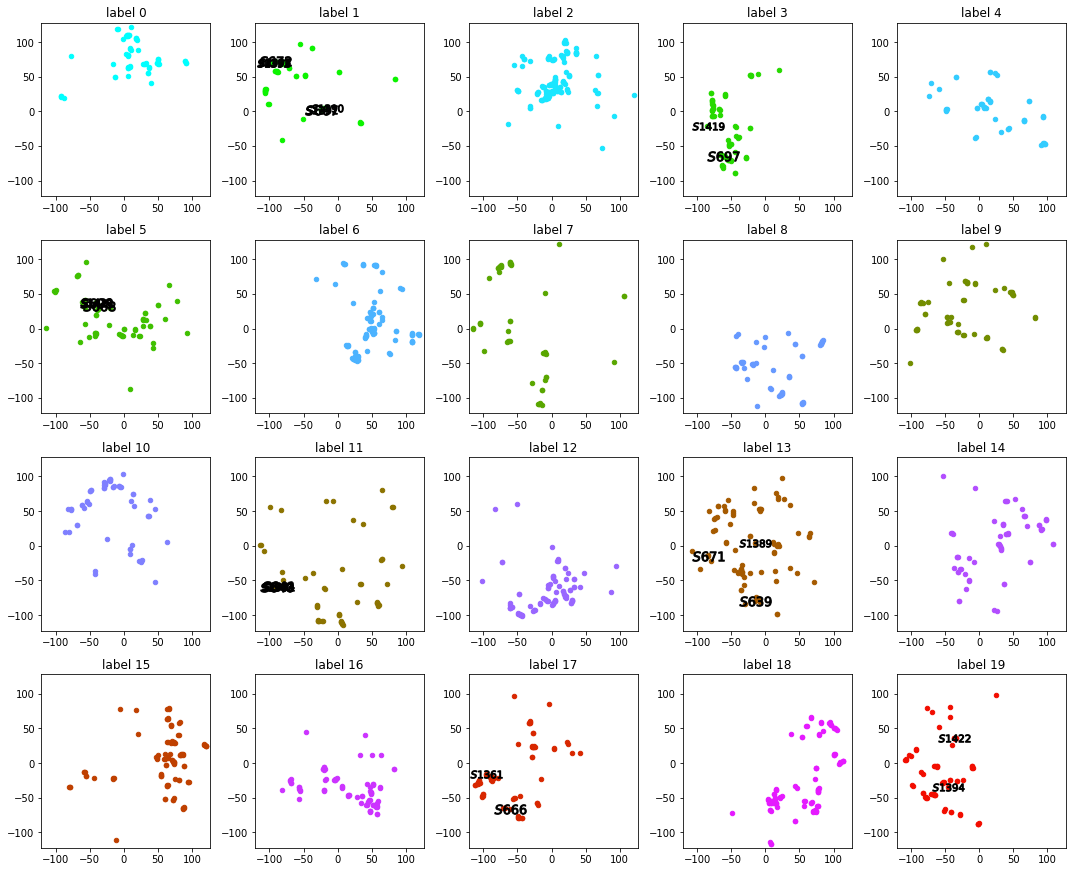

In [19]:
tsne_plots(tsne_hiddens[2], sparse_preds, shock_poses = shock_poses)

<Figure size 432x288 with 0 Axes>

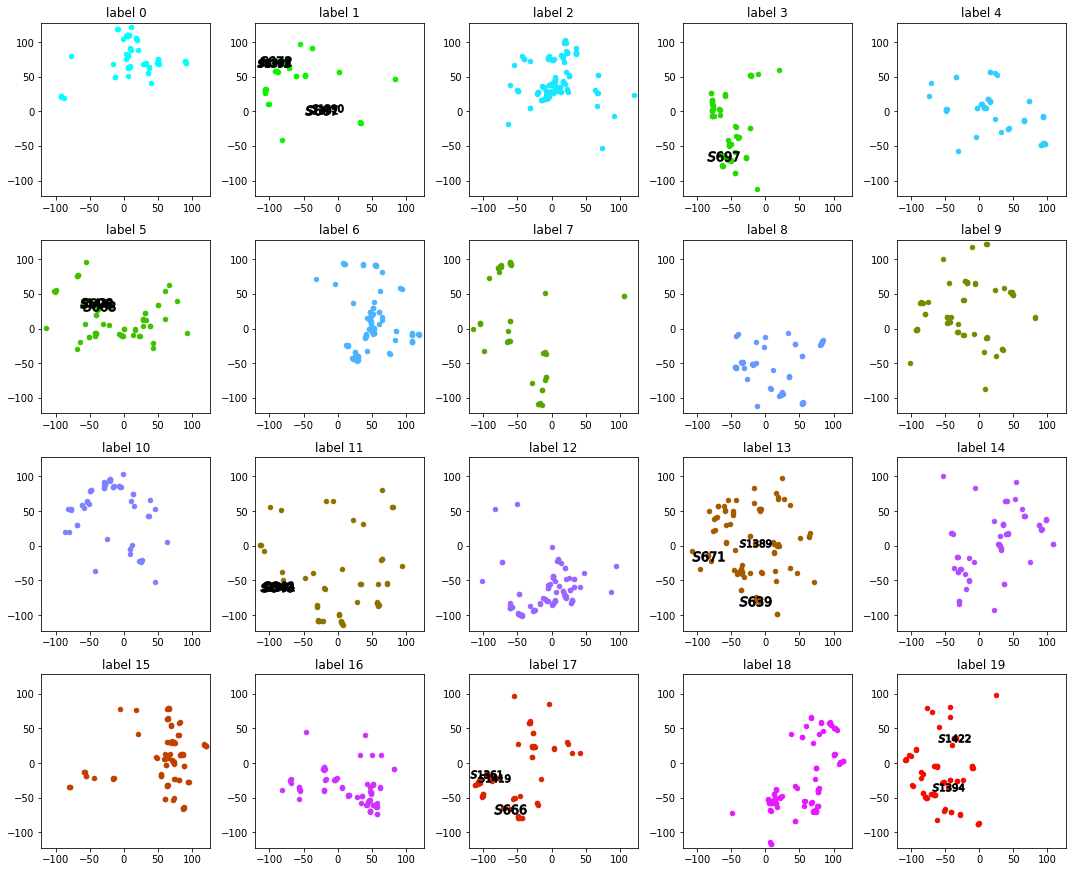

In [20]:
tsne_plots(tsne_hiddens[2], sparse_labels, shock_poses = shock_poses)

<Figure size 432x288 with 0 Axes>

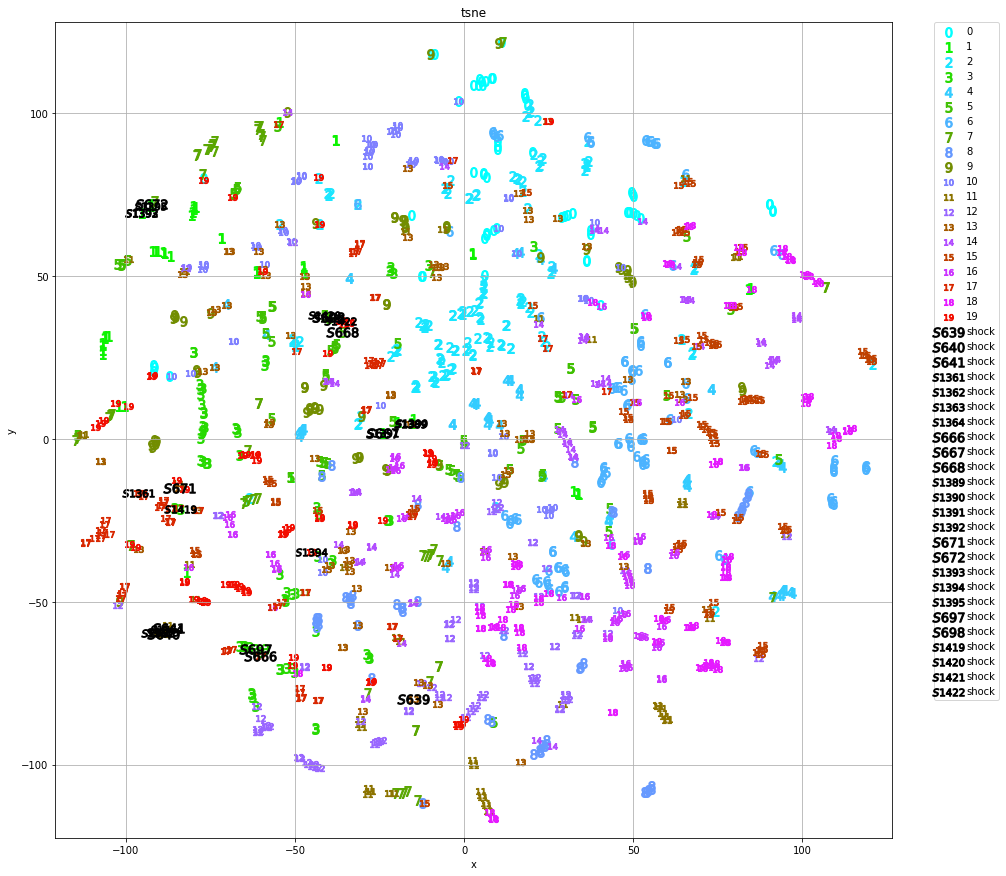

In [21]:
tsne_full_plot(tsne_hiddens[2], sparse_preds, shock_poses = shock_poses)

<Figure size 432x288 with 0 Axes>

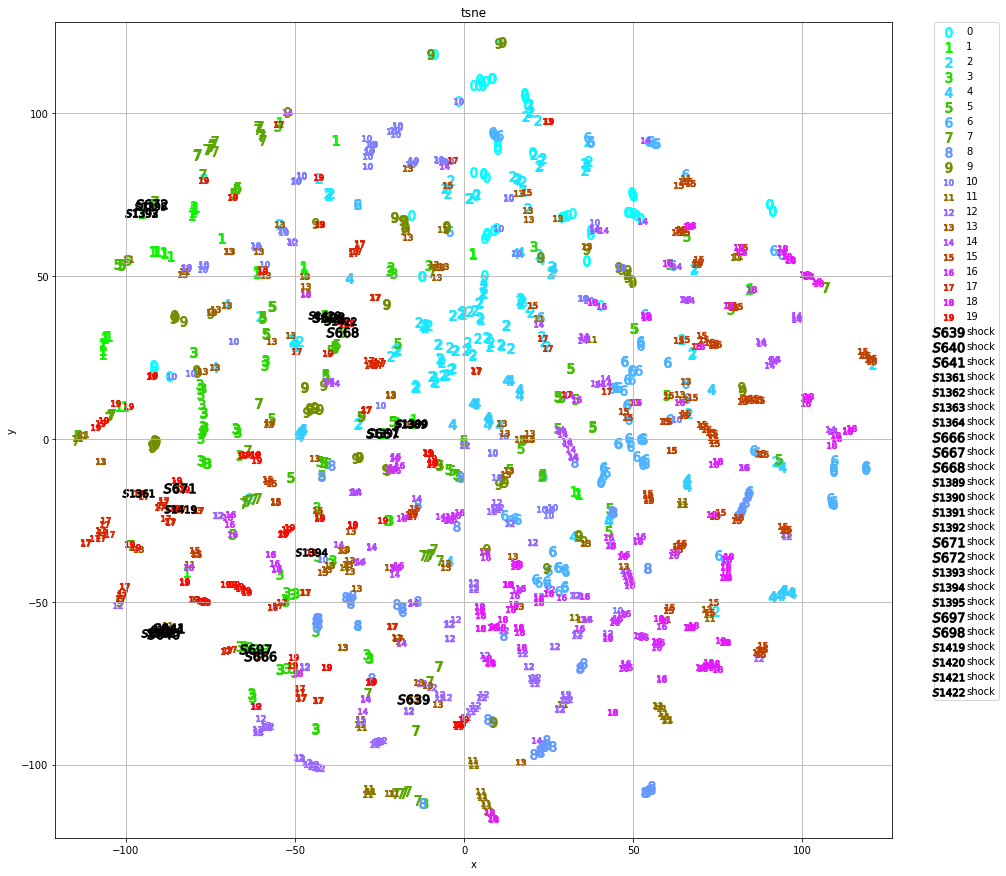

In [22]:
tsne_full_plot(tsne_hiddens[2], sparse_labels, shock_poses = shock_poses)

In [23]:
def label2dates(label, dates, labels):
    return [dates[i] for i, iter_label in enumerate(labels) if iter_label == label]

In [24]:
label2dates(3, sparse_dates, sparse_preds)

[('1966-11-23', '1967-02-21'),
 ('1988-01-07', '1988-04-05'),
 ('1992-10-22', '1993-01-21'),
 ('1999-12-03', '2000-03-01'),
 ('2000-01-03', '2000-03-29'),
 ('2002-01-02', '2002-04-01'),
 ('2002-01-31', '2002-04-29'),
 ('2002-03-01', '2002-05-28'),
 ('2003-02-12', '2003-05-09'),
 ('2003-10-29', '2004-01-27'),
 ('2004-05-20', '2004-08-17'),
 ('2004-12-10', '2005-03-09'),
 ('2005-05-05', '2005-08-01'),
 ('2007-07-06', '2007-10-01'),
 ('2007-08-03', '2007-10-29'),
 ('2007-08-31', '2007-11-28'),
 ('2008-05-22', '2008-08-19'),
 ('2010-02-01', '2010-04-28'),
 ('2010-05-26', '2010-08-20'),
 ('2011-03-15', '2011-06-09'),
 ('2011-04-12', '2011-07-08'),
 ('2014-06-27', '2014-09-24'),
 ('2016-12-19', '2017-03-17'),
 ('2017-01-19', '2017-04-17'),
 ('2017-02-16', '2017-05-15'),
 ('2017-06-13', '2017-09-08'),
 ('2017-10-06', '2018-01-04'),
 ('2017-11-03', '2018-02-02'),
 ('2018-03-05', '2018-05-30'),
 ('2018-05-01', '2018-07-27'),
 ('2018-06-27', '2018-09-24'),
 ('2018-11-19', '2019-02-21'),
 ('2018-

In [25]:
import heapq
class priority_queue:
    def __init__(self):
        self.key = lambda item: item[0] #アイテムの優先順位を指定
        self.index = 0
        self.data = []

    def push(self, item):
        heapq.heappush(self.data, (self.key(item), self.index, item))
        self.index += 1

    def pop(self):
        return heapq.heappop(self.data)[2]
    
    def size(self):
        return len(self.data)

In [26]:
def get_nearest_tsne(pos, tsne_hidden, labels, n = 10):
    pq = priority_queue()
    for i, vec in enumerate(tsne_hidden):
        if labels[pos] == labels[i]:
            dist = distance.euclidean(tsne_hidden[pos], vec)
            pq.push([dist, i])
    n_poses = []
    for i in range(min(n + 1, pq.size())):
        n_poses.append(pq.pop()[1])
    return n_poses[1:]

In [27]:
def get_nearest_hidden(pos, hidden_vecs, n = 10):
    t_vec = hidden_vecs[pos]
    pq = priority_queue()
    for i, vec in enumerate(hidden_vecs):
        dist = distance.euclidean(t_vec, vec)
        pq.push([dist, i])
    n_poses = []
    for i in range(min(n + 1, pq.size())):
        n_poses.append(pq.pop()[1])
    return n_poses[1:]

('2013-04-16', '2013-07-12')
('2013-03-14', '2013-07-24')
('2013-02-13', '2013-06-24')
('2013-04-12', '2013-08-21')
('2013-05-14', '2013-08-09')
('2013-05-10', '2013-09-19')
('2010-09-16', '2011-01-27')
('2011-11-28', '2012-04-09')
('2016-11-16', '2017-03-29')
('2015-02-18', '2015-06-26')


/home/kwk/share/mizuho/u00257/vae_clustering/src/lib/img_shows.py:154: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(np.ceil(np.sqrt(len(poses))).astype("int64"), np.ceil(np.sqrt(len(poses))).astype("int64"), i + 1)


<Figure size 432x288 with 0 Axes>

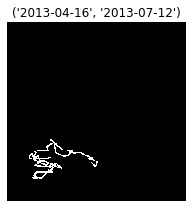

<Figure size 432x288 with 0 Axes>

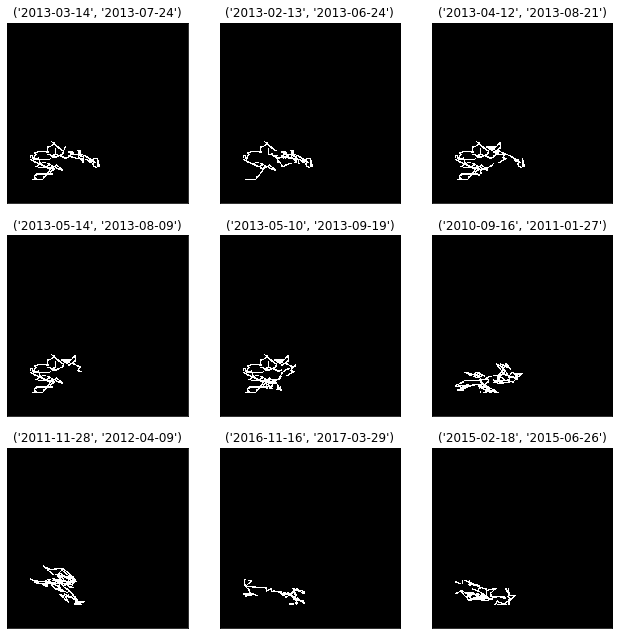

In [28]:
# バーナンキ
bernanke = 640
print(sparse_dates[bernanke])
nearests = get_nearest_tsne(bernanke, tsne_hiddens[2], sparse_preds, n = 9)
for i in nearests:
    print(sparse_dates[i])
imshow_cnn(sparse_dataset, sparse_dates, [bernanke], figsize=(3,3))
imshow_cnn(sparse_dataset, sparse_dates, nearests, figsize=(9,9))

('2015-06-16', '2015-09-10')
('2015-06-12', '2015-10-20')
('2012-08-20', '2012-11-15')
('2012-07-19', '2012-11-29')
('2015-05-14', '2015-09-22')
('2019-05-15', '2019-09-24')
('2009-04-09', '2009-08-18')
('2009-05-12', '2009-08-06')
('2009-05-08', '2009-09-16')
('1999-09-02', '2000-01-13')


<Figure size 432x288 with 0 Axes>

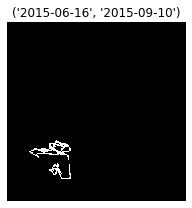

<Figure size 432x288 with 0 Axes>

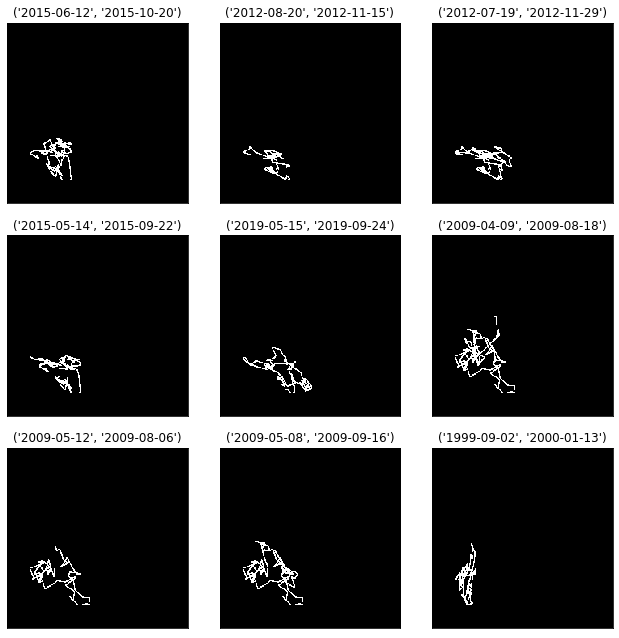

In [29]:
# china
china = 667
print(sparse_dates[china])
nearests = get_nearest_tsne(china, tsne_hiddens[2], sparse_labels, n = 9)
for i in nearests:
    print(sparse_dates[i])
imshow_cnn(sparse_dataset, sparse_dates, [china], figsize=(3,3))
imshow_cnn(sparse_dataset, sparse_dates, nearests, figsize=(9,9))

('2015-11-05', '2016-02-03')
('2015-10-06', '2016-02-16')
('2015-08-10', '2015-12-16')
('2015-07-13', '2015-11-17')
('2019-04-16', '2019-08-26')
('2019-04-18', '2019-07-17')
('2019-03-21', '2019-06-17')
('2019-03-19', '2019-07-29')
('2019-02-19', '2019-06-27')
('2016-10-18', '2017-03-01')


<Figure size 432x288 with 0 Axes>

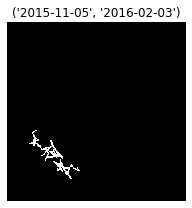

<Figure size 432x288 with 0 Axes>

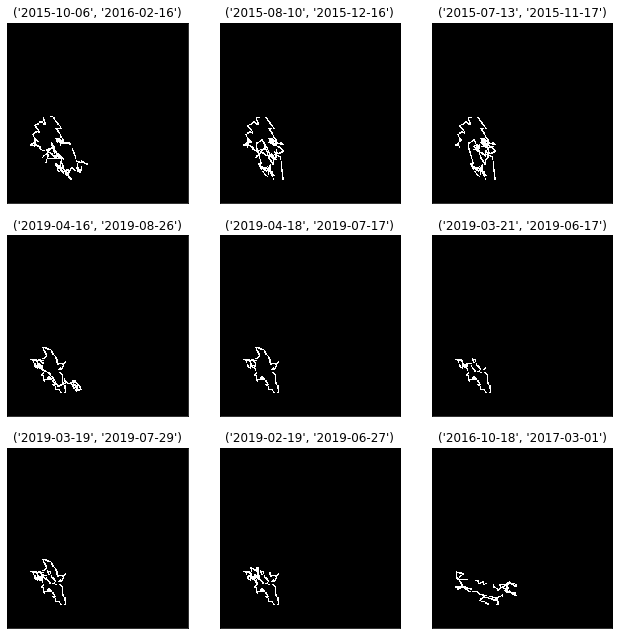

In [30]:
# glencore
glencore = 672
print(sparse_dates[glencore])
nearests = get_nearest_tsne(glencore, tsne_hiddens[2], sparse_labels, n = 9)
for i in nearests:
    print(sparse_dates[i])
imshow_cnn(sparse_dataset, sparse_dates, [glencore], figsize=(3,3))
imshow_cnn(sparse_dataset, sparse_dates, nearests, figsize=(9,9))

('2017-11-03', '2018-02-02')
('2017-10-06', '2018-01-04')
('2017-01-19', '2017-04-17')
('2010-02-01', '2010-04-28')
('2017-02-16', '2017-05-15')
('2017-01-17', '2017-05-25')
('2017-02-14', '2017-06-23')
('2018-05-01', '2018-07-27')
('2018-04-27', '2018-09-06')
('2018-05-25', '2018-10-04')


<Figure size 432x288 with 0 Axes>

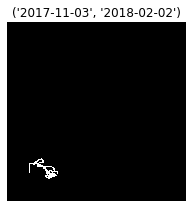

<Figure size 432x288 with 0 Axes>

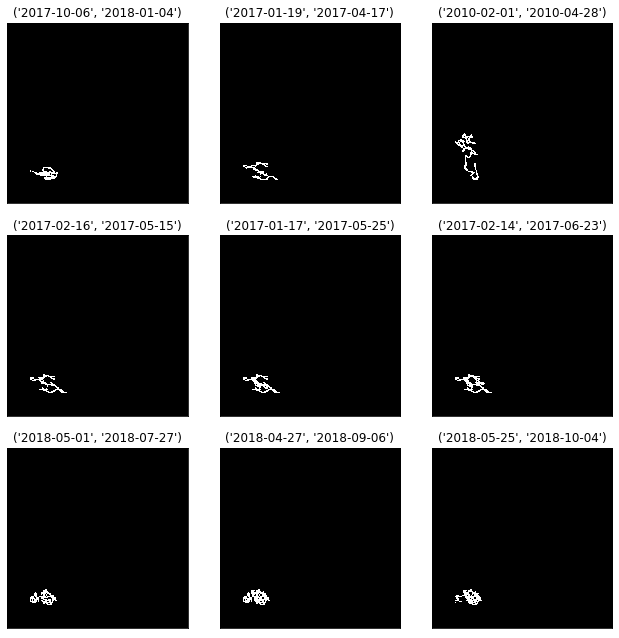

In [31]:
# VIX
vix = 697
print(sparse_dates[vix])
nearests = get_nearest_tsne(vix, tsne_hiddens[2], sparse_labels, n = 9)
for i in nearests:
    print(sparse_dates[i])
imshow_cnn(sparse_dataset, sparse_dates, [vix], figsize=(3,3))
imshow_cnn(sparse_dataset, sparse_dates, nearests, figsize=(9,9))

# ここからは古いデータ

<Figure size 432x288 with 0 Axes>

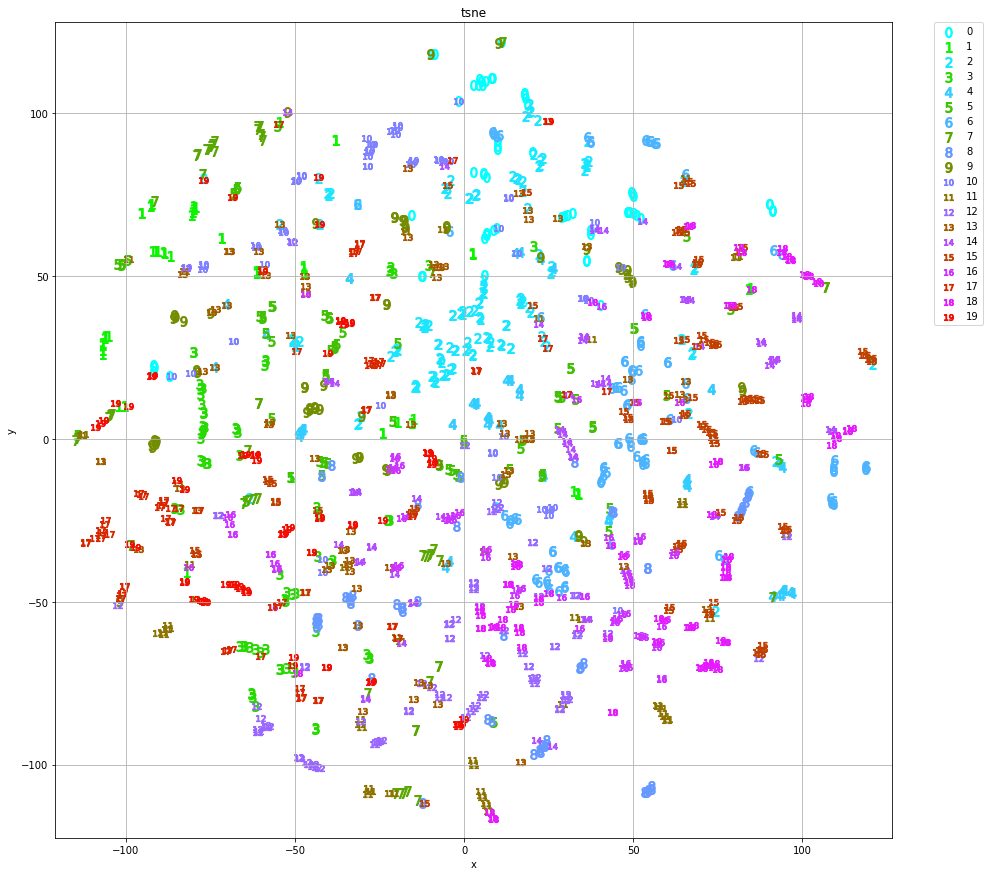

In [17]:
# tsne_full_plot(tsne_hiddens[0], sparse_preds)

<Figure size 432x288 with 0 Axes>

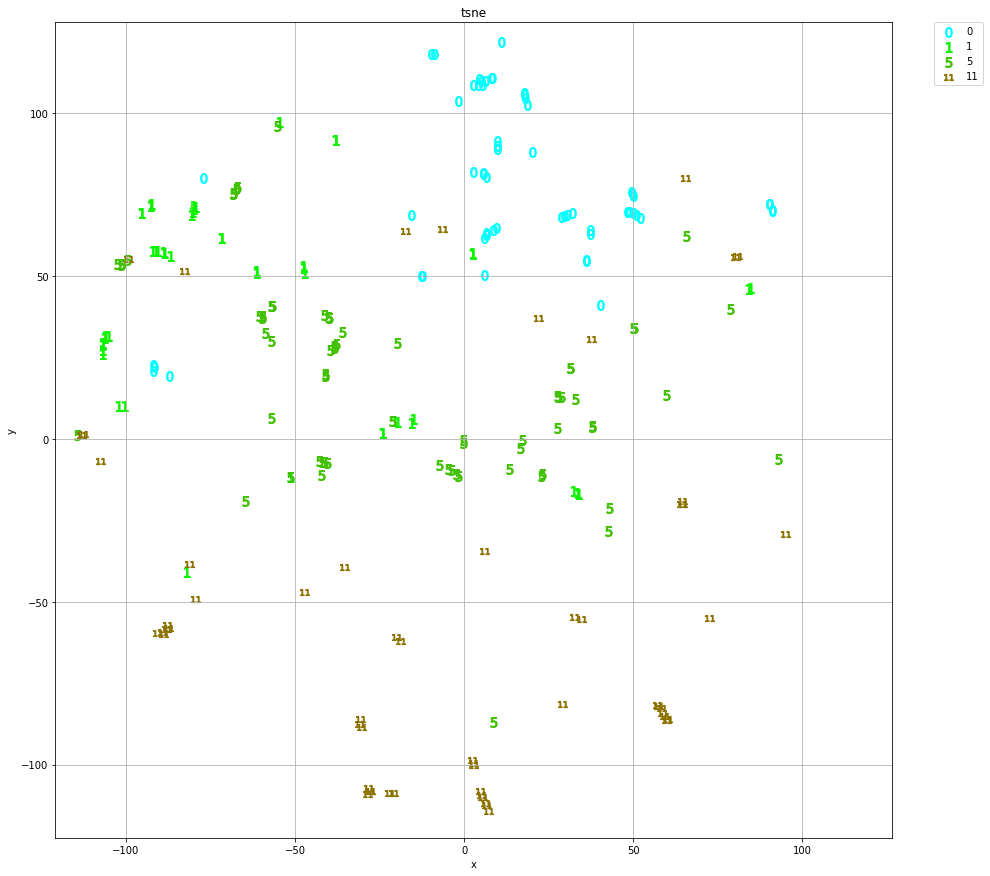

In [19]:
# tsne_full_plot(tsne_hiddens[2], sparse_preds, label_ranges=[0, 1, 5,11])